In [1]:
#资源网址:https://github.com/Cadene/pretrained-models.pytorch
#################################################################################################
#提供诸多模型!!!!且包含了Torchvison中的模型,并统一了模型模块和接口,如下,当实例化模型后,如名model,则有:
#model.input_space  一般为'RGB'(还有'BGR',很少)
#model.input_size:
#[3, 224, 224]或[3, 299, 299] #A系列:前者对应模型有:fbresnet/resnet/densenet/alexnet/vgg/wideresnet/系列,后者B系列:inception系列,及inceptionresnetv2/xception
#model.input_range  一般为[0, 1](还有[0, 255],很多少)
#model.mean   [0.485, 0.456, 0.406]或[0.5, 0.5, 0.5] #前者对应A系列,后者对应B系列
#model.std    [0.229, 0.224, 0.225]或[0.5, 0.5, 0.5] #前者对应A系列,后者对应B系列
#########例外:#######################
#如:nasnetalarge,'input_space': 'RGB','input_size': [3, 331, 331], # resize 354,'input_range': [0, 1],'mean': [0.5, 0.5, 0.5],'std': [0.5, 0.5, 0.5]
#如cafferesnet101/'caffevgg16', 'caffevgg19'采用'mean': [102.9801, 115.9465, 122.7717],'std': [1, 1, 1],'input_space': 'BGR',
#如dpn系列:'input_space': 'RGB','input_size': [3, 224, 224],'input_range': [0, 1],'mean': [124 / 255, 117 / 255, 104 / 255],'std': [1 / (.0167 * 255)] * 3
#如bninception:'input_space': 'BGR','input_size': [3, 224, 224],'input_range': [0, 255],'mean': [104, 117, 128],'std': [1, 1, 1],
#如vggm:'input_space': 'BGR','input_size': [3, 221, 221],'input_range': [0, 255],'mean': [123.68, 116.779, 103.939],'std': [1, 1, 1],
#如:wideresnet50和wideresnet152(有其文件,但还不可用!)
##################################################################################################
#把model封装成features,logits和forward三部分,并将前向分为:x = self.features(input)和x = self.logits(x),
#logits函数nn序列中一般为均值采样,维度flat和命名最后一层一般为"last_linear",使其改最终的预测类别数变的方便.
#logits: 未归一化的概率, 一般也就是 softmax层的输入(注:所有实例化的模型默认是不包含softmax计算概率层)
#装载权重时均采用:model.load_state_dict(model_zoo.load_url('**url**'))形式
#以上torch命令作用是Loads the Torch serialized object at the given URL,默认权参下载到.torch/目录下,目录下有权参则不会下载,没有则会自动下载

#torch.utils.model_zoo.load_url(url, model_dir=None, map_location=None)
#img = Image.open(os.path.join(self.path_images, path + '.jpg')).convert('RGB').resize((new_width, new_height), Image.ANTIALIAS)##resize image with high-quality
#labels = (np.asarray(row[1:num_categories + 1])).astype(np.float32)
#dir_models = os.path.join(expanduser("~"), '.torch/wideresnet')
###################################################################################
###定义的统一接口变为:***(num_classes=1000, pretrained='imagenet'),是一个函数,返回一个Module的子类序列对象
#如inceptionv4(num_classes=10, pretrained=None),可直接改最终分类数并从底训练,而inceptionv4(num_classes=1000, pretrained='imagenet')形式可装载预权重
#当用封装的torchvision模型时,由于最后一层改为last_linear,所以当densenet169(num_classes=1000, pretrained='imagenet')时,最后一层权参不会被预装入
#model.features :该方法用于提取特征
#可用于提取特征:output = model.features(input_224),print(output.size()) # (1,2048,1,1)
#当输入不是224时,output = model.features(input_448),# print(output.size())# (1,2048,7,7)

#model.logits   :该方法用于分类提取的特征,包含一些无参的池化和flatten及全连接,可能会出故障
#output = model.features(input_224) 
#print(output.size())               # (1,2048, 1, 1) 特征无flatten之前的维度!!!!
#output = model.logits(output)
#print(output.size())               # (1,1000)  特征flatten之后的维度!!!!

#model.forward: call model.features and model.logits. It can be overwritten as desired.
#output = model.forward(input_224)同output = model(input_224),后者调用了model.__call__
######################################################################################
#model.last_linear  : 所有预加载模型的最后一层 
#Can be replaced by an adapted nn.Linear for fine tuning.

# fine tuning
# dim_feats = model.last_linear.in_features # =2048
# nb_classes = 4
# model.last_linear = nn.Linear(dim_feats, nb_classes)
# output = model(input_224)
# print(output.size())               # (1,4)

# # features extraction
# model.last_linear = pretrained.utils.Identity()
# output = model(input_224)
# print(output.size())               # (1,2048)
######################################################################################
#新加层参考:
#nasnet倒数四层是:(relu): ReLU()/(avg_pool): AvgPool2d/(dropout): Dropout(p=0.5)/(last_linear): Linear(in_features=4032, out_features=1000, bias=True)
#inceptionresnetv2倒数三层:conv2d_7b(序列module),avgpool_1a,last_linear#in_features=1536, out_features=1000, bias=True#
#inceptionv4倒数两层是:(avg_pool): AvgPool2d/(last_linear): Linear(in_features=1536, out_features=1000, bias=True)
#resnext101_64x4d倒数两层是:(avg_pool): AvgPool2d/(last_linear): Linear(in_features=2048, out_features=1000, bias=True)
#xception倒数两层是:(bn4): BatchNorm2d/(last_linear): Linear(in_features=2048, out_features=1000, bias=True)
#dpn131倒数两层是:(conv5_bn_ac): CatBnAct((bn): BatchNorm2d,(act): ReLU(inplace))/(classifier): Conv2d

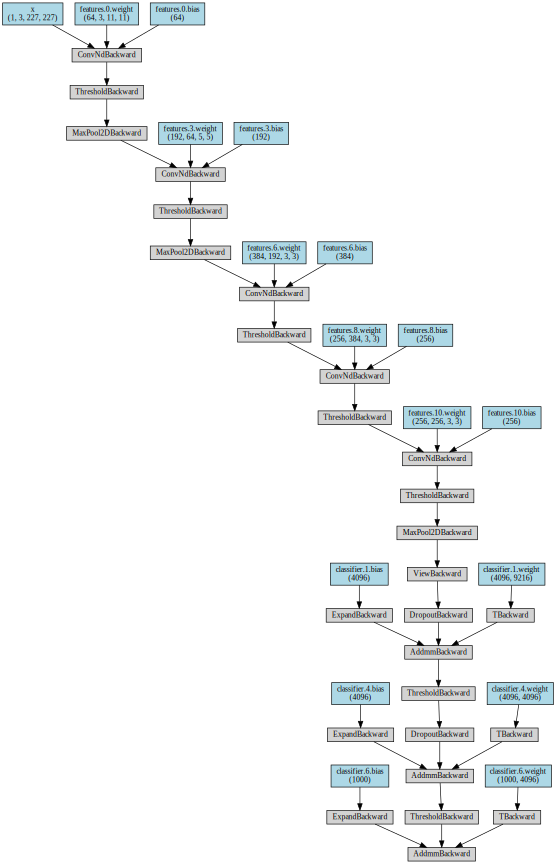

In [16]:
import torch
from torch.autograd import Variable
from torch import nn
from torchviz import make_dot, make_dot_from_trace
from torchvision.models import AlexNet

# model = AlexNet()

# x = Variable(torch.randn(1,3,227,227), requires_grad=True)
# y = model(x)
# make_dot( y, params=dict(list(model.named_parameters()) + [('x', x)]))
# model = nn.Sequential()
# model.add_module('W0', nn.Linear(8, 16))
# model.add_module('tanh', nn.Tanh())
# model.add_module('W1', nn.Linear(16, 1))

# x = Variable(torch.randn(1,8))
# y = model(x)

# make_dot(y.mean(), params=dict(model.named_parameters()))

In [7]:
import pretrainedmodels
#print(pretrainedmodels.model_names)
print(pretrainedmodels.__dict__['resnet18'])


<function resnet18 at 0x7f50a402af28>


In [3]:
print(pretrainedmodels.pretrained_settings['nasnetalarge'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth', 'input_space': 'RGB', 'input_size': [3, 331, 331], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1000}, 'imagenet+background': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth', 'input_space': 'RGB', 'input_size': [3, 331, 331], 'input_range': [0, 1], 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'num_classes': 1001}}


In [8]:
import torch
import torch.nn as nn
# import pretrainedmodels.utils as utils
#MODELS=[ 'nasnetalarge','inceptionresnetv2', 'inceptionv4', 'resnext101_64x4d', 'dpn131', 'dpn98',  'xception']

model_name = 'nasnetalarge' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet') #num_classes可改为你想要的类别
#print(nn.Sequential(*list(model.children())[:]))#模型用于前向预测,
print(model.named_parameters())
make_dot(params)
# #测试一张图像
# load_img = utils.LoadImage()#pretrainedmodels的自定义效用函数接口

# # transformations depending on the model
# # rescale, center crop, normalize, and others (ex: ToBGR, ToRange255)
# tf_img = utils.TransformImage(model) #pretrainedmodels的自定义效用函数接口

# path_img = 'data/cat.jpg'

# input_img = load_img(path_img)
# input_tensor = tf_img(input_img)         # 3x400x225 -> 3x299x299 size may differ
# input_tensor = input_tensor.unsqueeze(0) # 3x299x299 -> 1x3x299x299
# input = torch.autograd.Variable(input_tensor,
#     requires_grad=False)

# # Load Imagenet Synsets
# with open('data/imagenet_synsets.txt', 'r') as f:
#     synsets = f.readlines()

# # len(synsets)==1001
# # sysnets[0] == background
# synsets = [x.strip() for x in synsets]
# splits = [line.split(' ') for line in synsets]
# key_to_classname = {spl[0]:' '.join(spl[1:]) for spl in splits}
# with open('data/imagenet_classes.txt', 'r') as f:
#     class_id_to_key = f.readlines()
# class_id_to_key = [x.strip() for x in class_id_to_key]

# output_logits = model(input) # 1x1000

# #To extract features (beware this API is not available for all networks):
# output_features = model.features(input) # 1x14x14x2048 size may differ
# output_logits = model.logits(output_features) # 1x1000.此处计算的是未概率化的逻辑值
# max, argmax = output_logits.data.squeeze().max(0)
# class_id = argmax[0]
# class_key = class_id_to_key[class_id]
# classname = key_to_classname[class_key]
# print("'{}': '{}' is a '{}'".format(model_name, path_img, classname))

#nasnet倒数四层是:(relu): ReLU()/(avg_pool): AvgPool2d/(dropout): Dropout(p=0.5)/(last_linear): Linear(in_features=4032, out_features=1000, bias=True)
#inceptionresnetv2倒数三层:conv2d_7b(序列module),avgpool_1a,last_linear#in_features=1536, out_features=1000, bias=True#
#inceptionv4倒数两层是:(avg_pool): AvgPool2d/(last_linear): Linear(in_features=1536, out_features=1000, bias=True)
#resnext101_64x4d倒数两层是:(avg_pool): AvgPool2d/(last_linear): Linear(in_features=2048, out_features=1000, bias=True)
#xception倒数两层是:(bn4): BatchNorm2d/(last_linear): Linear(in_features=2048, out_features=1000, bias=True)
#dpn131倒数两层是:(conv5_bn_ac): CatBnAct((bn): BatchNorm2d,(act): ReLU(inplace))/(classifier): Conv2d

<generator object Module.named_parameters at 0x7f508036cf68>


In [5]:

# MODELS=['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 
#         'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 
#         'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 
#         'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 
#         'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetalarge', 'dpn68', 
#         'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception']
MODELS=[ 'nasnetalarge','inceptionresnetv2', 'inceptionv4', 'resnext101_64x4d', 'dpn131', 'dpn98',  'xception']
for model_name in MODELS:
    model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    print(model_name,' #Attr#','input_space:',model.input_space,'input_size:',model.input_size,'input_range:',model.input_range,'mean:',model.mean,'std:',model.std)

nasnetalarge  #Attr# input_space: RGB input_size: [3, 331, 331] input_range: [0, 1] mean: [0.5, 0.5, 0.5] std: [0.5, 0.5, 0.5]
inceptionresnetv2  #Attr# input_space: RGB input_size: [3, 299, 299] input_range: [0, 1] mean: [0.5, 0.5, 0.5] std: [0.5, 0.5, 0.5]
inceptionv4  #Attr# input_space: RGB input_size: [3, 299, 299] input_range: [0, 1] mean: [0.5, 0.5, 0.5] std: [0.5, 0.5, 0.5]
resnext101_64x4d  #Attr# input_space: RGB input_size: [3, 224, 224] input_range: [0, 1] mean: [0.485, 0.456, 0.406] std: [0.229, 0.224, 0.225]
dpn131  #Attr# input_space: RGB input_size: [3, 224, 224] input_range: [0, 1] mean: [0.48627450980392156, 0.4588235294117647, 0.40784313725490196] std: [0.23482446870963955, 0.23482446870963955, 0.23482446870963955]
dpn98  #Attr# input_space: RGB input_size: [3, 224, 224] input_range: [0, 1] mean: [0.48627450980392156, 0.4588235294117647, 0.40784313725490196] std: [0.23482446870963955, 0.23482446870963955, 0.23482446870963955]
xception  #Attr# input_space: RGB input_s

/home/slb/anaconda2/envs/py36_pytorch/lib/python3.6/site-packages/torch/nn/modules/module.py:514: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)
